# Ruby-Throated Hummingbird Migration into North America


### by Renee Marie Parilak Teate
Data from http://ebird.org/content/ebird/

*eBird Basic Dataset. Version: EBD_relAug-2015. Cornell Lab of Ornithology, Ithaca, New York. Aug 2015.*

Python 3.5.1 with pandas 0.17.1, numpy 1.10.4, seaborn 0.7.0

<a href="Hummingbird%20Migration%20Interactive%20Jupyter%20Notebook.ipynb">File with code visible</a>

### *Questions to be answered: *
- *When can we expect the first Ruby-Throated Hummingbirds to reach X location in their northward migration?*
- *What is the range of the Ruby-Throated Hummingbird by Y date?*

In [29]:
#import libraries needed for this analysis
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from bokeh.plotting import *
from bokeh.models import Range1d

### This dataset contains over 367,000 Ruby-throated hummingbird sightings from January 2013 to August 2015, capturing 3 years of south-to-north migration

In [30]:
# read in text file
df = pd.read_csv('ebird_rubythroated_Jan2013_Aug2015.txt', sep='\t', index_col='GLOBAL UNIQUE IDENTIFIER', 
                 error_bad_lines=False, warn_bad_lines=False, low_memory=False)


#### Here is an example of all fields in one row of the dataset

In [31]:
print(df.iloc[2000,:])

TAXONOMIC ORDER                                               8896
CATEGORY                                                   species
COMMON NAME                              Ruby-throated Hummingbird
SCIENTIFIC NAME                               Archilochus colubris
SUBSPECIES COMMON NAME                                         NaN
SUBSPECIES SCIENTIFIC NAME                                     NaN
OBSERVATION COUNT                                                1
BREEDING BIRD ATLAS CODE                                       NaN
AGE/SEX                                                        NaN
COUNTRY                                                     Canada
COUNTRY_CODE                                                    CA
STATE_PROVINCE                                       New Brunswick
SUBNATIONAL1_CODE                                            CA-NB
COUNTY                                                   Charlotte
SUBNATIONAL2_CODE                                         CA-N

### We're going to narrow down the data to just location information and observation dates. 
#### For this analysis, we only care about the month and year since we're looking for earliest sightings by locality over a 3-year period (not comparing year over year), so we'll create a column that treats all observations as if they happened during one year.

In [32]:
# narrow dataset down to just columns we need
df_loc_date = df.loc[:,('COUNTRY','STATE_PROVINCE','LOCALITY','COUNTY','LATITUDE','LONGITUDE','OBSERVATION DATE')]
# put the month, year, and date into their own columns
df_loc_date['OBS MONTH'] = df_loc_date['OBSERVATION DATE'].str[5:7].astype(int)
df_loc_date['OBS DAY'] = df_loc_date['OBSERVATION DATE'].str[8:10].astype(int)
df_loc_date['OBS YEAR'] = df_loc_date['OBSERVATION DATE'].str[0:4].astype(int)
# pretend they're all in the same year so we can get earliest month and day and treat like a date
df_loc_date['OBS MONTHDAY'] = '2014-' + df_loc_date['OBSERVATION DATE'].str[5:10].astype(str) 
df_loc_date['OBS MONTHDAY'] = pd.to_datetime(df_loc_date['OBS MONTHDAY'])
# add columns for rounded latitude and longitude to make it less granular
df_loc_date['SHORT LAT'] = df_loc_date['LATITUDE'].round(0)
df_loc_date['SHORT LONG'] = df_loc_date['LONGITUDE'].round(0)

# get the earliest sighting in any year by short long and short lat group
df_first_seen = df_loc_date.loc[:,('SHORT LAT','SHORT LONG','OBS MONTHDAY')].groupby(['SHORT LAT','SHORT LONG']).min()

### We made the latitude and longitude data less granular by rounding to the nearest whole-number latitude and longitude.

#### This gives us fewer points, but we have more data points per 'location" to calculate minimum date seen. (We don't need to know at the neighborhood level, city/county/region is good enough. Then we'll have more data points per location.)

### Let's visualize the change of granularity to make sure the result will still be meaningful. 

#### This Seaborn chart shows Latitude 36-39, approximately covering the "height" of the state of Virginia.


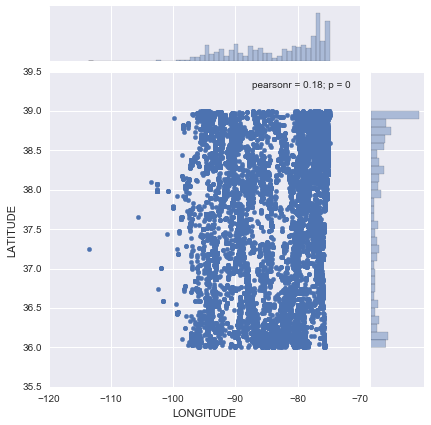

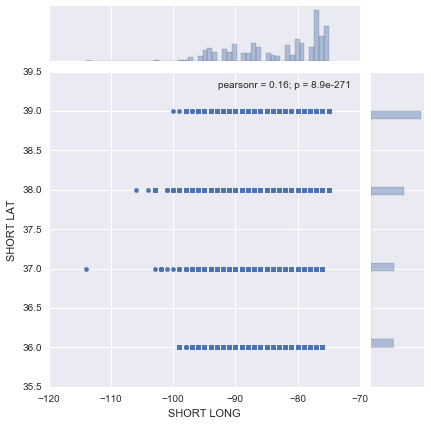

In [33]:
#show the plot here instead of in pop-up
%matplotlib inline
# seaborn joint plot with latitude and longitude
sns.jointplot("LONGITUDE", "LATITUDE", data=df_loc_date.where((df_loc_date['LATITUDE'] > 36) & (df_loc_date['LATITUDE'] < 39 )))
sns.plt.show()
# seaborn joint plot with less-granular latitude and longitude
sns.jointplot("SHORT LONG", "SHORT LAT", data=df_loc_date.where((df_loc_date['LATITUDE'] > 36) & (df_loc_date['LATITUDE'] < 39 )))
sns.plt.show()

### Now let's look at the new "rounded" data points on an actual Google map to see if our coverage is good.


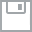
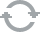
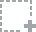
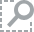
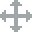
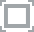
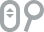
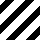
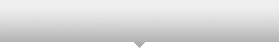
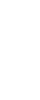
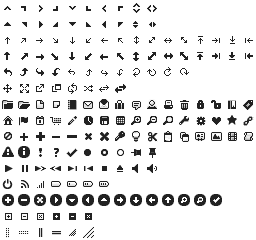
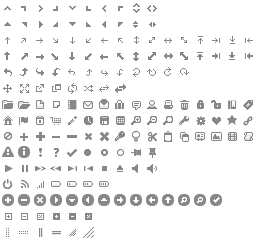
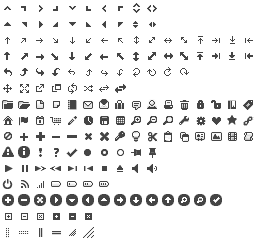
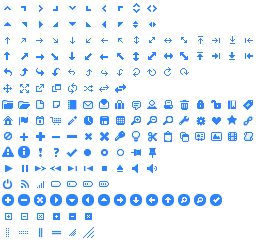
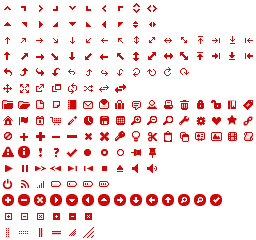
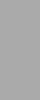
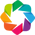
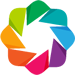

In [34]:
# Google Map bokeh code from http://bokeh.pydata.org/en/latest/docs/user_guide/geo.html
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, BoxZoomTool
)
map_options = GMapOptions(lat=35, lng=-90, map_type="roadmap", zoom=3)
plot = GMapPlot(
    x_range=DataRange1d(), y_range=DataRange1d(), map_options=map_options, title="Google Map"
)
#get the grouped data, but reset index so can refer to the columns normally. plot all rounded lat-long data points
plotdata = df_first_seen 
plotdata = plotdata.reset_index()
source = ColumnDataSource(
    data=dict(
        lat= plotdata['SHORT LAT'],
        lon= plotdata['SHORT LONG']
    )
)
circle = Circle(x="lon", y="lat", size=8, fill_color="blue", fill_alpha=0.8, line_color=None)
plot.add_glyph(source, circle)
plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool(), BoxZoomTool())

#set plots to show up inline
output_notebook()
show(plot)

### Here is an example of an "earliest seen" date for a location - the minimum date of an observation at a lat-long point in the grouped data

In [35]:
# access the earliest seen date value by short lat&long index
print(df_first_seen.dtypes)
print(df_first_seen.ix[9,-84])
#show the number of points
print("\nNumber of values:",df_first_seen.shape[0])

OBS MONTHDAY    datetime64[ns]
dtype: object
OBS MONTHDAY   2014-01-12
Name: (9.0, -84.0), dtype: datetime64[ns]

Number of values: 879


### Let's see how the week-number of first observations are distributed 

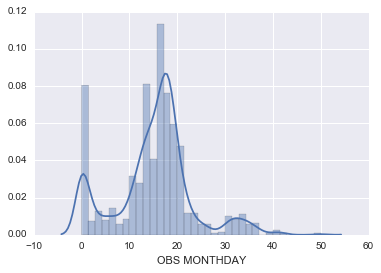

In [36]:
#seaborn histogram (distribution plot) of week of year of min sighting date per location
sns.distplot(df_first_seen['OBS MONTHDAY'].apply(lambda x: int((x.timetuple().tm_yday/7))))
sns.plt.show()

In [37]:
#import packages needed for bokeh plots on date-related data
from bokeh.palettes import Spectral6

#create labels for "map" plot
p = figure(title = "Ruby-Throated Hummingbird Migration Map (colors tied to week of 1st observation)")
p.xaxis.axis_label = 'Longitude'
p.yaxis.axis_label = 'Latitude'
p.title_text_font_size = '8'

#determine the range or values for which to set colors
high = plotdata['OBS MONTHDAY'].max().timetuple().tm_yday/7 #highest year day in resulting set
low = plotdata['OBS MONTHDAY'].min().timetuple().tm_yday/7 #lowest year day in resulting set
#print(int(low),int(high)) #weeks 1 to 52
matrix = [ ([i*85] * 13) for i in range(4) ]
#add week of year value to each row
plotdata['WOY'] = plotdata['OBS MONTHDAY'].apply(lambda x: int((x.timetuple().tm_yday/7/((high-low)/52))))
r = [x for row in reversed(matrix) for x in row]# [x*4.4 for x in range(0,53)]
g = [x*4.4 for x in range(0,53)]
b = [x for row in matrix for x in row] #need one more value
b.append(255)
r.append(0)
#convert numeric values to hex values
colors = [
    "#%02x%02x%02x" % (int(r), 50, int(b)) for r,g,b in zip(r,g,b)
 ]
color_dict = {}
#assign a hex color to each value for first sighting 0-52 weeks
color_dict = dict(zip(range(0,53),colors))
#print(color_dict)
#assign colors to values in table to be plotted
colors = [color_dict[x*2] if x < 26 else color_dict[52] for x in plotdata['WOY']] #added *2 to skip though these colors faster, until > 26, then stay at max

#create and display the "map"
#p.circle(plotdata['SHORT LONG'], plotdata['SHORT LAT'],fill_color=colors, line_color = None, fill_alpha = 0.8 )
#show(p)

### Below we create a "map" that shows the hummingbird range by plotting the location points colorized by the week of first sighting. The user can choose the location in human-readable form

In [38]:
# get the earliest sighting in any year by short long and short lat group
df_first_city_state = df_loc_date.loc[:,('SHORT LAT','SHORT LONG','COUNTRY','STATE_PROVINCE','COUNTY','LOCALITY','OBS MONTHDAY')].groupby(['COUNTRY','STATE_PROVINCE','COUNTY'])
df_first_city_state = df_first_city_state.agg({'OBS MONTHDAY' : np.min, 'SHORT LAT': np.mean, 'SHORT LONG': np.mean})


In [39]:
#allow the user to enter input from available countries, states, and cities
from ipywidgets import *
from IPython.display import display

#the locations with nan counties won't show up right on the map, so for now just filter them out of the dropdown choices
df_select_locs = df_loc_date[pd.notnull(df_loc_date['COUNTY'])]

#countries
countryselect = widgets.Dropdown(
    options=df_select_locs['COUNTRY'].unique().tolist(),
    value = 'United States',
    description='Country:',
)
#states
stateselect = widgets.Dropdown(
    options=df_select_locs['STATE_PROVINCE'][df_loc_date['COUNTRY']==countryselect.value].unique().tolist(),
    value = 'Virginia',
    description='State/Province:',
)
#counties
coselect = widgets.Dropdown(
    options=df_select_locs['COUNTY'][df_loc_date['STATE_PROVINCE']==stateselect.value].unique().tolist(),
    value = 'Harrisonburg',
    description='County:',
)

def mapMigrationByCity(country, state, co):
    #this triggers on-change, so also reset dropdown selection values
    stateselect.options = df_loc_date['STATE_PROVINCE'][df_loc_date['COUNTRY']==countryselect.value].unique().tolist()
    coselect.options = df_loc_date['COUNTY'][df_loc_date['STATE_PROVINCE']==stateselect.value].unique().tolist()
    
    #when a location is selected, try to find a data point for the entered combination
    idx = pd.IndexSlice
    try:
        df_city_state_co_summary = df_first_city_state.loc[idx[country,state,co],:]
    except:
        df_city_state_co_summary = []
        print("Combination of country=",country,", state=", state, " and county=", co, "not found.")      
        
    if len(df_city_state_co_summary) > 0:
        #show the latitude and longitude and earliest sighting for the location selected
        print('AVG LATITUDE:',df_city_state_co_summary['SHORT LAT'])
        print('AVG LONGITUDE:',df_city_state_co_summary['SHORT LONG'])
        obs_mon = df_city_state_co_summary['OBS MONTHDAY'].timetuple().tm_mon
        obs_day = df_city_state_co_summary['OBS MONTHDAY'].timetuple().tm_mday
        print('EARLIEST SIGHTING:',str(obs_mon)+'/'+str(obs_day))

        #display the points on the map for first-observations by this date
        max_date = pd.to_datetime('2014-' + str(obs_mon).zfill(2) + '-' + str(obs_day).zfill(2))
        plotdata_date = plotdata[plotdata['OBS MONTHDAY'] <= max_date]

        #create labels for "map" plot (not using google map this time)
        p2 = figure(title = "Ruby-Throated Hummingbird Migration Through " + str(obs_mon)+'/'+str(obs_day))
        p2.xaxis.axis_label = 'Longitude'
        p2.yaxis.axis_label = 'Latitude'
        p2.xaxis.bounds = [-130,-50]
        p2.yaxis.bounds = [5,60]
        p2.x_range = Range1d(-130,-50)
        p2.y_range = Range1d(5,60)
        p2.title_text_font_size = '8'
        colors = [color_dict[x*2] if x < 26 else color_dict[52] for x in plotdata_date['WOY']] 
        p2.circle(plotdata_date['SHORT LONG'], plotdata_date['SHORT LAT'],fill_color=colors, line_color = None, fill_alpha = 0.8 )
        #get the actual color of the small dot representing the location we want to show as a bigger dot
        plotdata_loc = plotdata_date.loc[(plotdata_date['SHORT LONG'] == df_city_state_co_summary['SHORT LONG'].round(0)) & 
                                         (plotdata_date['SHORT LAT'] == df_city_state_co_summary['SHORT LAT'].round(0) )]
        color2 = [color_dict[x*2] if x < 26 else color_dict[52] for x in plotdata_loc['WOY']]
        #larger point to indicate selected location on map
        p2.circle_x(plotdata_loc['SHORT LONG'], plotdata_loc['SHORT LAT'],fill_color=color2, line_color = "black", fill_alpha = 0.8, size=15 )
        show(p2)


## *Q: When can we expect the first Ruby-Throated Hummingbirds to reach X location in their northward migration?*

## A: Select a Country, State, and County from the Dropdowns. The date of first arrival is shown in the map title, and the selected location is highlighted on the map, showing the range as of that date.

In [40]:
interact(mapMigrationByCity,country=countryselect, state=stateselect, co=coselect)

AVG LATITUDE: 38.0
AVG LONGITUDE: -79.0
EARLIEST SIGHTING: 5/2


<function __main__.mapMigrationByCity>

### Now we'll show an interactive map "animating" the range by day of year

In [41]:
#show map with distribution by this date
#mon_day = '0501'
myslider = IntSlider(min=1,max=365,description="Day of Year")
myslider.value = 60
#display(myslider)


def mapMigrationByDate(md):
    max_date = datetime.datetime(2014, 1, 1) + datetime.timedelta(md - 1)
    plotdata_date = plotdata[plotdata['OBS MONTHDAY'] <= max_date]
    #print(plotdata_date)
    obs_mon2 = max_date.timetuple().tm_mon
    obs_day2 = max_date.timetuple().tm_mday
    
    #create new map plot
    #create labels for "map" plot
    p3 = figure(title = "Ruby-Throated Hummingbird Migration Through " + str(obs_mon2)+'/'+str(obs_day2))
    p3.xaxis.axis_label = 'Longitude'
    p3.yaxis.axis_label = 'Latitude'
    # fixed axes on this one for visual effect
    p3.xaxis.bounds = [-130,-50]
    p3.yaxis.bounds = [5,60]
    p3.x_range = Range1d(-130,-50)
    p3.y_range = Range1d(5,60)
    p3.title_text_font_size = '8'
    colors = [color_dict[x*2] if x < 26 else color_dict[52] for x in plotdata_date['WOY']] #added *2 to skip though these colors faster, until > 26, then stay at max
    #map points
    p3.circle(plotdata_date['SHORT LONG'], plotdata_date['SHORT LAT'],fill_color=colors, line_color = None, fill_alpha = 0.8 )
    show(p3)


## *Q: What is the range of the Ruby-Throated Hummingbird by Y date?*

## A: Use the slider to change the day of the year. The date is shown in the map title, and the points for the locations where hummingbirds have been observed by that date are shown.

In [42]:
interact(mapMigrationByDate,md=myslider)
mapMigrationByDate(60)